In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    GridSearchCV
)
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    PolynomialFeatures
)
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree, 
    ExtraTreeClassifier
)
from sklearn.metrics import classification_report

In [2]:
df_raw = pd.read_csv('../../data/diabetes.csv')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
X = df_raw.iloc[:,:8]
y = df_raw.iloc[:,-1]

In [5]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

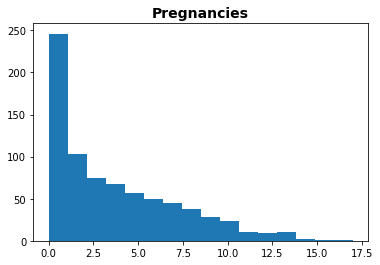

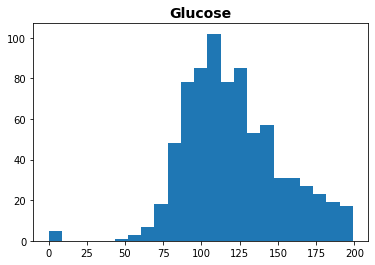

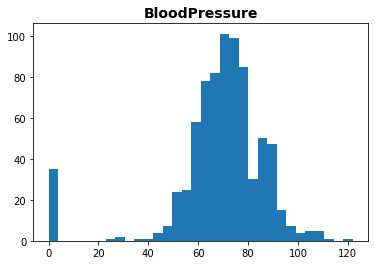

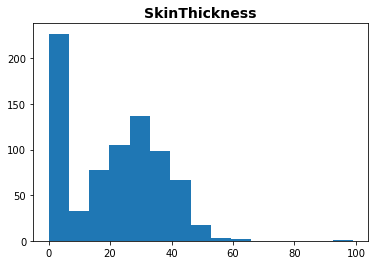

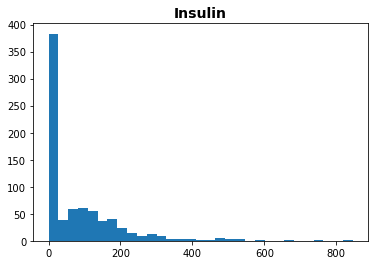

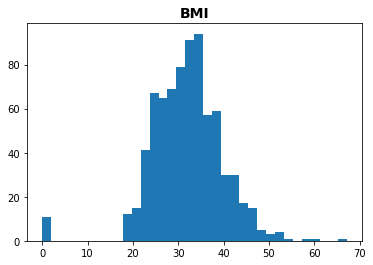

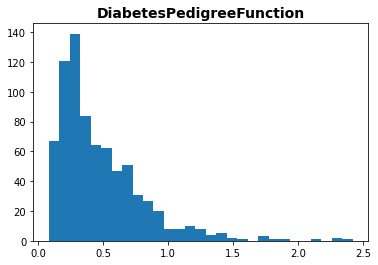

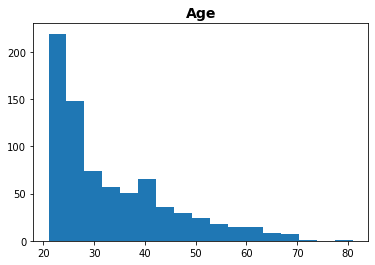

In [6]:
# Distribuição das variaveis
col_names = X.columns
for col in col_names:
    fig, ax = plt.subplots()
    ax.hist(X[col], bins='auto')
    ax.set_title(f'{col}', fontweight="bold", fontsize=14)
    plt.show()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [8]:
cols_quantile = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
all_cols = list(X.columns)

pipe_model = Pipeline(steps=[
    ('prep_data', ColumnTransformer([
        ('qt', Pipeline([
            ('qt_transf', PowerTransformer()),
        ]), all_cols),
        ('norm', Pipeline([
            ('std', StandardScaler())
        ]), all_cols)
    ])),
    ('model', GaussianNB()),
    
])


In [9]:
scores = cross_validate(pipe_model, X_train, y_train, cv=3, return_train_score=True)

In [10]:
print(pd.DataFrame(data=scores))

   fit_time  score_time  test_score  train_score
0  0.036029    0.006002    0.770732     0.745721
1  0.029006    0.006000    0.731707     0.775061
2  0.033003    0.007002    0.754902     0.782927


In [11]:
# Queremos melhorar a metrica vamos tratar as variaveis de uma maneira diferente
# pegando as colunas que são assimetricas 
cols_assimetricas = []
for i in range(len(X.skew())):
    if X.skew()[i] > 0.263 or X.skew()[i] < 0.263:
        cols_assimetricas.append(X.skew().index[i])

all_cols = list(X.columns)

quantile_pipe = Pipeline([('quantile', QuantileTransformer())])
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA())
    ])
preprocess = ColumnTransformer([
    ("quantile_pipe", quantile_pipe, cols_assimetricas),
    ("num_pipe", num_pipe, all_cols)
])

feat_select = SelectKBest(score_func=chi2, k=3)

pipe = Pipeline([
    ("preprocess", preprocess),
#     ("feat_select", feat_select),
    ("model", DummyClassifier())
])

pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('quantile_pipe',
                                                  Pipeline(steps=[('quantile',
                                                                   QuantileTransformer())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('model', DummyClassifier())])

In [12]:
param = [
    dict(
        preprocess__num_pipe__poly__degree=[2,3],
        preprocess__num_pipe__poly__interaction_only=[True],
        preprocess__num_pipe__pca__n_components=[14,15,16],
), dict(
        model=[DecisionTreeClassifier()],
        model__criterion=['gini', 'entropy', 'log_loss'],
        model__max_depth=[5,8,13,15,18],
        model__max_features=['auto', 'sqrt', 'log2', None],
        preprocess__num_pipe__poly__degree=[2,3],
        preprocess__num_pipe__poly__interaction_only=[True, False],
        preprocess__num_pipe__pca__n_components=[5,10,15,0.95],
), dict(
        model=[RandomForestClassifier()],
        model__n_estimators=[50,100,200],
        model__max_depth=[5,8,13,15,18],
        model__max_features=['auto', 'sqrt', 'log2', None],
        preprocess__num_pipe__poly__degree=[2,3],
        preprocess__num_pipe__poly__interaction_only=[True, False],
        preprocess__num_pipe__pca__n_components=[5,10,15,0.95],
), dict(
    model=[GaussianNB]
), dict(
        model=[LogisticRegression()],
        model__C=[0.5,0.8,0.9,1,1.2,1.3,1.5],
        preprocess__num_pipe__poly__degree=[2,3],
        preprocess__num_pipe__poly__interaction_only=[True, False],
        preprocess__num_pipe__pca__n_components=[5,10,15,0.95],
       )
    
]

In [20]:
param = [dict(
    model=[RandomForestClassifier()],
    model__n_estimators=[20,50,100],
    model__max_depth=[5,8,13,15,18],
    model__max_features=['auto', 'sqrt', 'log2', None],
    preprocess__num_pipe__poly__degree=[2,3,4],
    preprocess__num_pipe__poly__interaction_only=[True, False],
    preprocess__num_pipe__pca__n_components=[5,10,15,0.95],
), dict(
    model=[GradientBoostingClassifier()],
    model__n_estimators=[20,50,100,250],
    model__max_depth=[3,5,8,13,15,18],
    preprocess__num_pipe__poly__degree=[2,3,4],
    preprocess__num_pipe__pca__n_components=[5,10,15,0.95], 
)]

In [21]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
grid = GridSearchCV(pipe, param, cv=3, scoring='accuracy', n_jobs=-1, verbose=10) 
grid.fit(X_train, y_train) 
print(grid.best_score_)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


C:\Users\luiz_\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(


0.788235294117647


In [22]:
grid.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features='log2'),
 'model__max_depth': 8,
 'model__max_features': 'log2',
 'model__n_estimators': 100,
 'preprocess__num_pipe__pca__n_components': 15,
 'preprocess__num_pipe__poly__degree': 4,
 'preprocess__num_pipe__poly__interaction_only': True}

In [23]:
y_pred = grid.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        95
           1       0.64      0.64      0.64        59

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



In [26]:
quantile_pipe = Pipeline([('quantile', QuantileTransformer())])
num_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15))
    ])
preprocess = ColumnTransformer([
    ("quantile_pipe", quantile_pipe, cols_assimetricas),
    ("num_pipe", num_pipe, all_cols)
])

feat_select = SelectKBest(score_func=f_classif, k=3)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("feat_select", feat_select),
    ("model", DummyClassifier())
])

pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('quantile_pipe',
                                                  Pipeline(steps=[('quantile',
                                                                   QuantileTransformer())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=4)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=15))]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('feat_select', SelectKBest(k=3)),
                ('model', DummyClassifier())])

In [37]:
param = dict(
    model=[RandomForestClassifier()],
    model__n_estimators=[20,50,100,1000],
    model__max_depth=[5,8,13,15,18,20],
    feat_select__k=[1,2,3,4,5,6,7,8,9,10]
)

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
grid = GridSearchCV(pipe, param, cv=3, scoring='accuracy', n_jobs=-1, verbose=10) 
grid.fit(X_train, y_train) 
print(grid.best_score_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
0.7867049258727882


C:\Users\luiz_\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(


In [39]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        95
           1       0.61      0.59      0.60        59

    accuracy                           0.70       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.70      0.70      0.70       154



In [35]:
grid.best_params_

{'feat_select__k': 8,
 'model': RandomForestClassifier(max_depth=15, n_estimators=20),
 'model__max_depth': 15,
 'model__n_estimators': 20}

In [60]:
param = dict(
    model=[RandomForestClassifier(random_state=0)],
    model__n_estimators=[10,15,20,25,30],
    model__max_depth=[13,14,15,16,17],
    feat_select__k=[1,2,3,4,5,6,7,8,9,10]
)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
grid = GridSearchCV(pipe, param, cv=3, scoring='accuracy', n_jobs=-1, verbose=10) 
grid.fit(X_train, y_train) 
print(grid.best_score_)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
0.7687709230033476


C:\Users\luiz_\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(


In [61]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



In [58]:
# Veja como melhorar a acuracia